In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

batch_size = 32
img_height = 128
img_width = 128
data_dir = os.path.join(os.getcwd(), 'images', 'handsigns')
testdata_dir = os.path.join(os.getcwd(), 'images', 'testhandsigns')
test_labels = None


In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 100 files belonging to 4 classes.
Using 80 files for training.


In [3]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 4 classes.
Using 20 files for validation.


In [4]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testdata_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4 files belonging to 4 classes.


In [5]:
class_names = train_ds.class_names
test_labels = train_ds.class_names
print(class_names)

['fivefingers', 'middlefinger', 'peace', 'thumb']


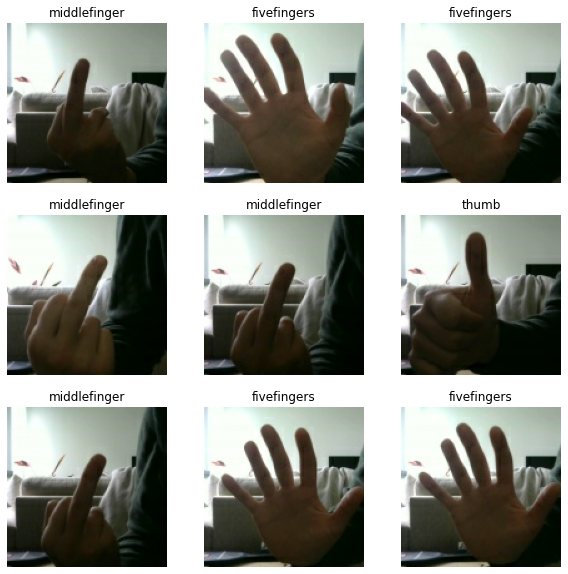

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [8]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)


Epoch 1/10
3/3 [==============================] - 1s 116ms/step - loss: 1.4000 - accuracy: 0.1875 - val_loss: 1.3254 - val_accuracy: 0.5500
Epoch 2/10
3/3 [==============================] - 0s 16ms/step - loss: 1.1877 - accuracy: 0.5875 - val_loss: 1.3057 - val_accuracy: 0.2500
Epoch 3/10
3/3 [==============================] - 0s 16ms/step - loss: 1.0990 - accuracy: 0.4750 - val_loss: 1.1212 - val_accuracy: 0.6000
Epoch 4/10
3/3 [==============================] - 0s 15ms/step - loss: 0.9044 - accuracy: 0.8125 - val_loss: 0.9089 - val_accuracy: 0.8000
Epoch 5/10
3/3 [==============================] - 0s 15ms/step - loss: 0.6568 - accuracy: 0.8625 - val_loss: 0.6911 - val_accuracy: 0.8500
Epoch 6/10
3/3 [==============================] - 0s 15ms/step - loss: 0.4381 - accuracy: 0.9375 - val_loss: 0.4909 - val_accuracy: 0.9000
Epoch 7/10
3/3 [==============================] - 0s 16ms/step - loss: 0.2909 - accuracy: 0.9750 - val_loss: 0.2631 - val_accuracy: 0.9500
Epoch 8/10
3/3 [==========

In [12]:
model.evaluate(test_ds)
print(test_ds)


1/1 [==============================] - 0s 37ms/step - loss: 2.6370 - accuracy: 0.7500
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>


In [13]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_ds)
i = 0
for predict in predictions:
    print(predict)
    print(np.argmax(predict))
    if test_labels[i] == test_labels[np.argmax(predict)]:
        print('correct')
    print(test_labels[np.argmax(predict)])
    print("_____________________")
    i = i+1







[9.9999988e-01 4.9521351e-08 2.6892778e-08 1.2756989e-07]
0
correct
fivefingers
_____________________
[7.4718770e-04 9.8932368e-01 4.8665454e-05 9.8804124e-03]
1
correct
middlefinger
_____________________
[5.8648543e-04 2.5540146e-01 1.3158731e-04 7.4388045e-01]
3
thumb
_____________________
[1.6106516e-03 9.9318039e-01 3.5667337e-05 5.1733493e-03]
1
middlefinger
_____________________


### 